In [1]:
HOST = '37.139.42.145'
DBNAME = 'game-analytics'
USER = 'analytics'
PASSWORD = 'BRtTaqYiJyr29WXN'
import pandas as pd
from sqlalchemy import create_engine
engine = create_engine(f'postgresql://{USER}:{PASSWORD}@{HOST}/{DBNAME}')
TABLE_SCHEMA ='data_viz_1068.project_dataset'


In [ ]:
installs= pd.read_sql(f'''
    SELECT  event_date, count(DISTINCT user_id) as users, user_type, region
    FROM data_viz_1068.project_dataset
    WHERE event_name = 'FirstLaunchApp'
    GROUP BY event_date, user_type, region
''', con=engine)

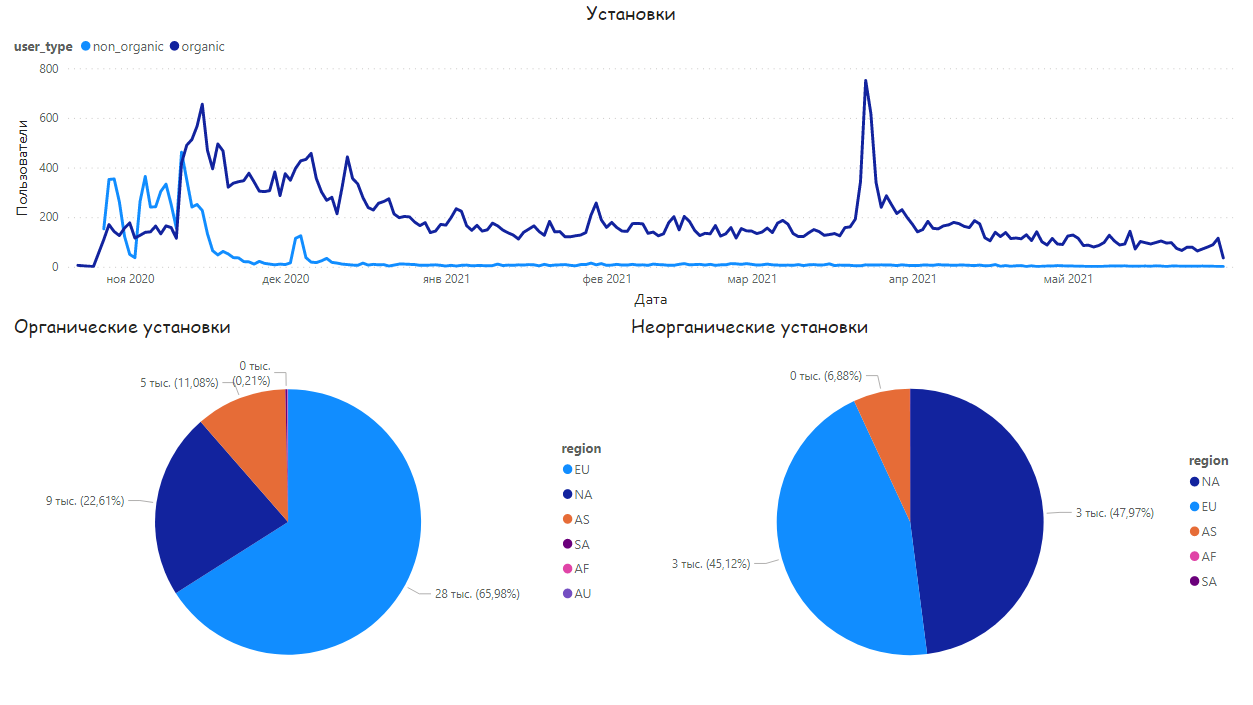

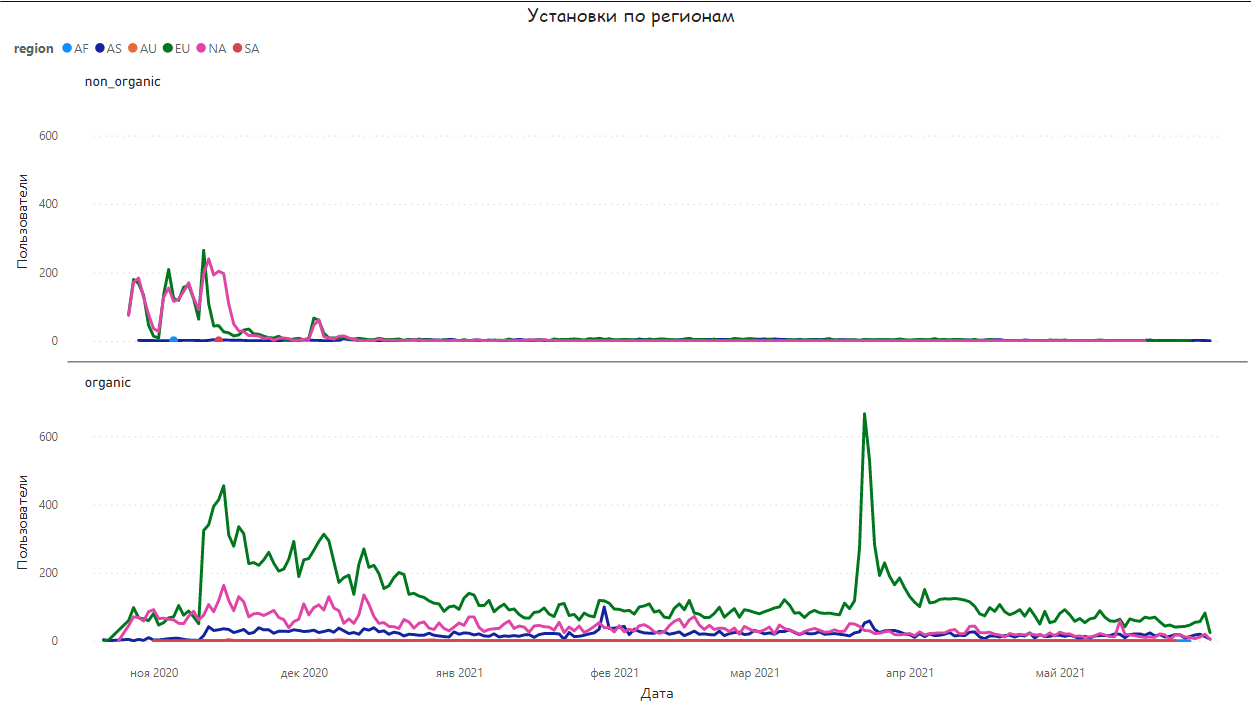

Вывод: Смотря на данные грфики можно увидеть, что в конце марта  2021 года был очень высокий скачек органических установок. для более точного анализа, необходимо рассмотреть, чем может быть вызван данный скачек и есть ли взаимосвязь с каким либо регионом. Для этого обратимся к графику "Установки по регионам" - на данном графике видно, что скачек коснулся только Европу (EU). Возможно это связанно с локальной акцией или рекламой известной личности. Говоря о динамике органического трафика в целом, после января 2021 года рост сократился и стабилизировался до средних показателей - 200-300 инсталов, при этом большая часть установок идет из EU, NA, AS. Региональное соотношение неорганического трафика такое же, но установки приходятся только на ноябрь - декабрь 2020 года, после чего не достигают даже 50 инсталов в сутки. Возможно это связвно с неудачным выбором кампаний или прекращение инвестирования.

In [6]:
df = pd.read_sql(f'''  
   with sessions as
   (SELECT region, count(DISTINCT user_id)  as installs, count(DISTINCT user_id) filter (WHERE user_id in
    (SELECT DISTINCT user_id
     FROM data_viz_1068.project_dataset
     WHERE event_name = 'LaunchApp' and user_id in
    (SELECT DISTINCT user_id
     FROM data_viz_1068.project_dataset
     WHERE event_name = 'FirstLaunchApp')))as LaunchApp
    FROM data_viz_1068.project_dataset
    WHERE event_name = 'FirstLaunchApp'
    GROUP BY region)
    
    SELECT region, installs, launchapp, cast(launchapp as float)/cast(installs as float)*100 as percent
    FROM sessions
''', con=engine)
df

,region,installs,launchapp,percent
0,AF,29,21,72.413793
1,AS,2804,2086,74.393723
2,AU,18,15,83.333333
3,EU,25083,18171,72.443488
4,NA,11169,8916,79.828096
5,SA,67,46,68.656716


Вывод: В Австралии самый высокий процент конверсии во вторую сессию, но меньше всех установок, поэтому можно рассмотреть те регионы, кто процент конверсии во вторую сесию поменьше. На втором месте стоит Северная Америка  у нее гораздо больше инсталов и неплохая конверсия во вторую сессию.

In [ ]:
df = pd.read_sql(f'''  
   with data as
   (SELECT event_time, user_id, region, user_type, event_name,
    min(event_time) filter (WHERE event_name = 'FirstLaunchApp') OVER (PARTITION BY user_id) as install_time 
    FROM data_viz_1068.project_dataset
    WHERE user_id in 
        (SELECT user_id
         FROM data_viz_1068.project_dataset
         WHERE event_name = 'FirstLaunchApp'))
    
    SELECT event_name, user_type, region, count(DISTINCT user_id) as users, count(event_name) as events
    FROM data
    WHERE event_time <= (install_time + interval '1' day)    
    GROUP BY event_name, user_type, region
''', con=engine)

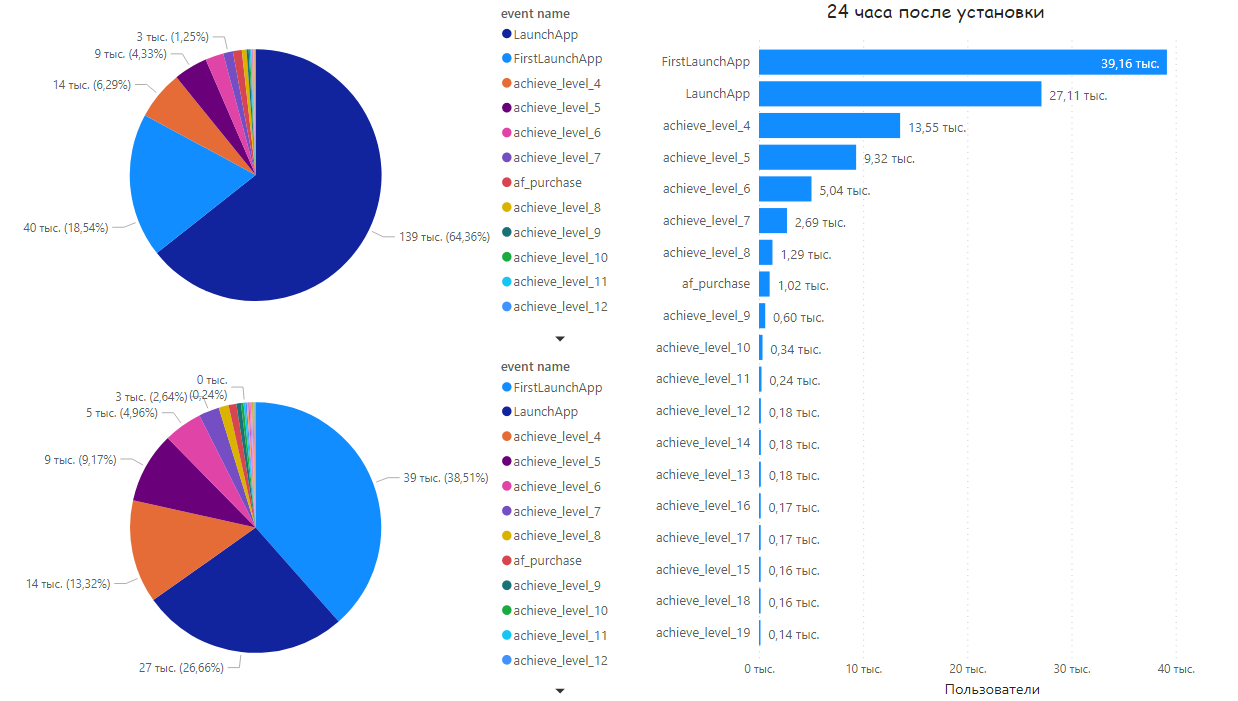

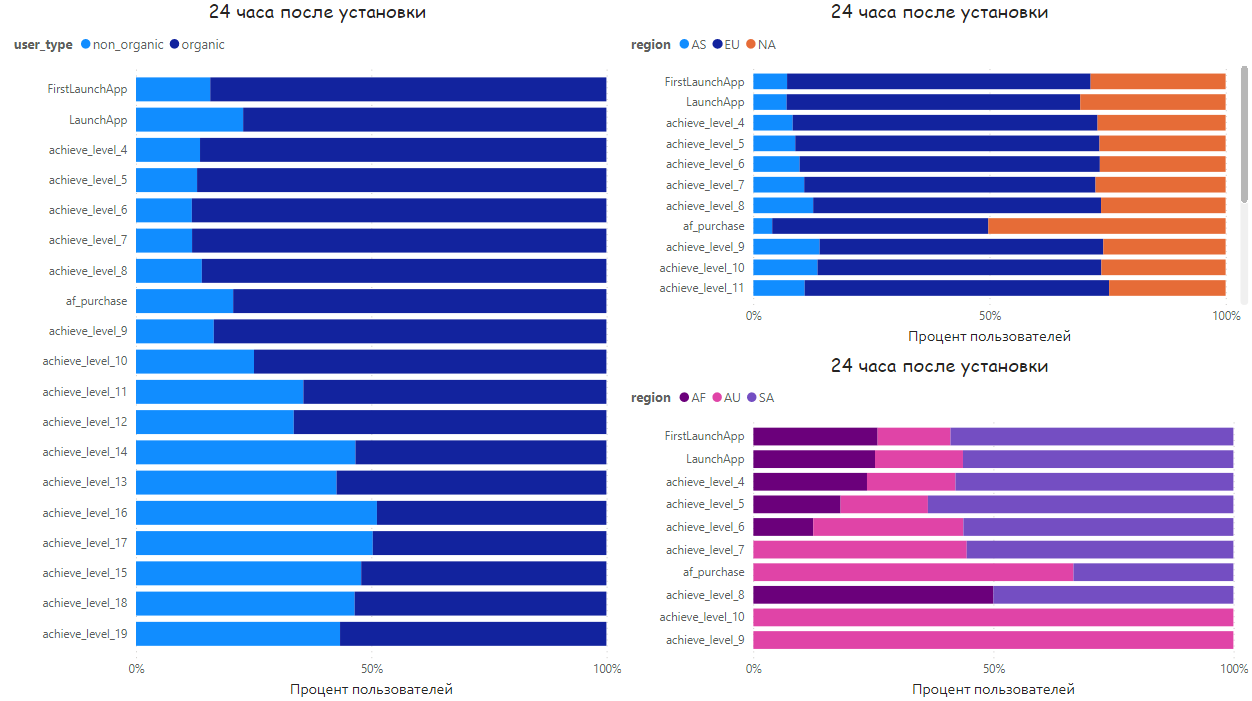

Вывод: Рассматрия поведение игроков за первые 24 часа после установки, можно увидеть, что почти 25% игроков не доходят до второй сессии, а 50% от оставшихся не проходят 4ый уровень. Несмотря на то, что неорганических пользователей мало - почти все кто установил игру, совершают свой первый платеж в первые 24 часа после установки. Говоря о более высоких уровнях, препологаю, что пользователи достигают их позже. Рассматривая активности по регионам, можно сделать вывод, что все события происходят примерно одинаково в процентгом соотношении к числу установок, за исключением платежа - в Северной Америке, платежей больше.